Câu 1: Từ bộ dữ liệu Iris (sử dụng Python để lấy bộ dữ liệu), hãy sử dụng truy vấn SQL để triển khai thuật toán Naïve Bayes. Trong đó, hãy chỉ rõ đặc trưng nào là biến dự đoán và đặc trưng nào là biến phân loại và phân tách dữ liệu training:testing theo tỷ lệ 90%:10%.

In [5]:
import sqlite3, math
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# 1. tải bộ dữ liệu
predictors = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target = 'species'

print(" Biến dự đoán:", predictors)
print(" Biến phân loại:", target)
print()

iris = load_iris()
df = pd.DataFrame(iris.data, columns=predictors)
df[target] = [iris.target_names[i] for i in iris.target]

# 2. Chia train:test = 90:10 (stratify)
train, test = train_test_split(df, test_size=0.1, stratify=df[target], random_state=42)
train['split'], test['split'] = 'train', 'test'
df_all = pd.concat([train, test])

# 3. Lưu vào SQLite
conn = sqlite3.connect(':memory:')
cur = conn.cursor()
cur.execute("""
CREATE TABLE iris (
    sepal_length REAL, sepal_width REAL, 
    petal_length REAL, petal_width REAL, 
    species TEXT, split TEXT)
""")
for row in df_all.itertuples(index=False):
    cur.execute("INSERT INTO iris VALUES (?, ?, ?, ?, ?, ?)", tuple(row))
conn.commit()

# 4. Tính toán Naïve Bayes 
cur.execute("""
CREATE VIEW stats AS
SELECT species,
  COUNT(*)*1.0 / (SELECT COUNT(*) FROM iris WHERE split='train') AS prior,
  AVG(sepal_length) AS m1, AVG(sepal_length*sepal_length)-AVG(sepal_length)*AVG(sepal_length) AS v1,
  AVG(sepal_width)  AS m2, AVG(sepal_width*sepal_width) -AVG(sepal_width)*AVG(sepal_width)  AS v2,
  AVG(petal_length) AS m3, AVG(petal_length*petal_length)-AVG(petal_length)*AVG(petal_length) AS v3,
  AVG(petal_width)  AS m4, AVG(petal_width*petal_width) -AVG(petal_width)*AVG(petal_width)  AS v4
FROM iris WHERE split='train' GROUP BY species
""")
params = {
    r[0]: {'prior': r[1], 'mean': r[2:9:2], 'var': r[3:10:2]}
    for r in cur.execute("SELECT * FROM stats")
}

# 5. Hàm Gaussian 
def gprob(x, mu, var):
    var = max(var, 1e-9)
    return (1 / (math.sqrt(2*math.pi*var))) * math.exp(-((x - mu) ** 2) / (2 * var))

# 6. Dự đoán và đánh giá
test_rows = cur.execute("SELECT sepal_length, sepal_width, petal_length, petal_width, species FROM iris WHERE split='test'").fetchall()
correct = 0
for *x, true in test_rows:
    pred = max(params, key=lambda cls: math.log(params[cls]['prior']) + sum(
        math.log(gprob(xi, mu, var)) for xi, mu, var in zip(x, params[cls]['mean'], params[cls]['var'])
    ))
    correct += pred == true
# 9. Kết quả
n_test = len(test_rows)
print(f" Test samples:           {n_test}")
print(f" Correctly classified:   {correct}")
print(f" Accuracy: {correct}/{len(test_rows)} = {correct / len(test_rows):.2%}")


 Biến dự đoán: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
 Biến phân loại: species

 Test samples:           15
 Correctly classified:   13
 Accuracy: 13/15 = 86.67%


- Biến dự đoán gồm 4 đặc trưng: sepal_length, sepal_width, petal_length, petal_width

- Biến phân loại: species (loài hoa Iris)
- Tổng số mẫu kiểm tra (test samples): 15
- Số mẫu phân loại đúng: 13
- Độ chính xác (accuracy): 86.67%
- Mô hình đạt độ chính xác khá cao (86.67%) chỉ với một tập test nhỏ (15 mẫu), cho thấy các đặc trưng đầu vào mang tính phân biệt tốt giữa các loài hoa.

Câu 2: Sử dụng python để đọc file dữ liệu House Pricing. Hãy thực hiện các yêu cầu sau kết hợp với SQL:
- Mô tả chi tiết về bài toán, các biến đặc trưng.
- Thực hiện quá trình xử lý dữ liệu cần thiết trước khi đưa vào mô hình, nêu rõ các bước và kết quả.
- Hãy xác định hai biến dự đoán và biến cần dự đoán cho mô hình hồi quy tuyến tính đơn giản. Huấn luyện mô hình và có nhận xét gì sau khi thu được kết quả

In [11]:
import pandas as pd
import sqlite3
import random
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Tải dataset 
df = pd.read_csv("D:/chuong_4/data_house.csv")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.info(), df.describe(), df.head()


Shape: (21613, 22)
Columns: ['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21613 non-null  int64  
 1   id             21613 non-null  int64  
 2   date           21613 non-null  object 
 3   price          21613 non-null  float64
 4   bedrooms       21613 non-null  int64  
 5   bathrooms      21613 non-null  float64
 6   sqft_living    21613 non-null  int64  
 7   sqft_lot       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   waterfront     21613 non-null  int64  
 10  view           21613 non-null  int64  
 11  condition      21613 non-n

(None,
         Unnamed: 0            id         price      bedrooms     bathrooms  \
 count  21613.00000  2.161300e+04  2.161300e+04  21613.000000  21613.000000   
 mean   10806.00000  4.580302e+09  5.400881e+05      3.370842      2.114757   
 std     6239.28002  2.876566e+09  3.671272e+05      0.930062      0.770163   
 min        0.00000  1.000102e+06  7.500000e+04      0.000000      0.000000   
 25%     5403.00000  2.123049e+09  3.219500e+05      3.000000      1.750000   
 50%    10806.00000  3.904930e+09  4.500000e+05      3.000000      2.250000   
 75%    16209.00000  7.308900e+09  6.450000e+05      4.000000      2.500000   
 max    21612.00000  9.900000e+09  7.700000e+06     33.000000      8.000000   
 
         sqft_living      sqft_lot        floors    waterfront          view  \
 count  21613.000000  2.161300e+04  21613.000000  21613.000000  21613.000000   
 mean    2079.899736  1.510697e+04      1.494309      0.007542      0.234303   
 std      918.440897  4.142051e+04      

In [12]:
# 2. Xử lý dữ liệu

df2 = df.drop(columns=['Unnamed: 0','id','date','zipcode','lat','long'])

print("giá trị thiếu trước xử lý:\n", df2.isna().sum(), "\n")
df2 = df2.dropna()
print("sau khi xử lý:", df2.shape, "\n")

giá trị thiếu trước xử lý:
 price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
sqft_living15    0
sqft_lot15       0
dtype: int64 

sau khi xử lý: (21613, 16) 



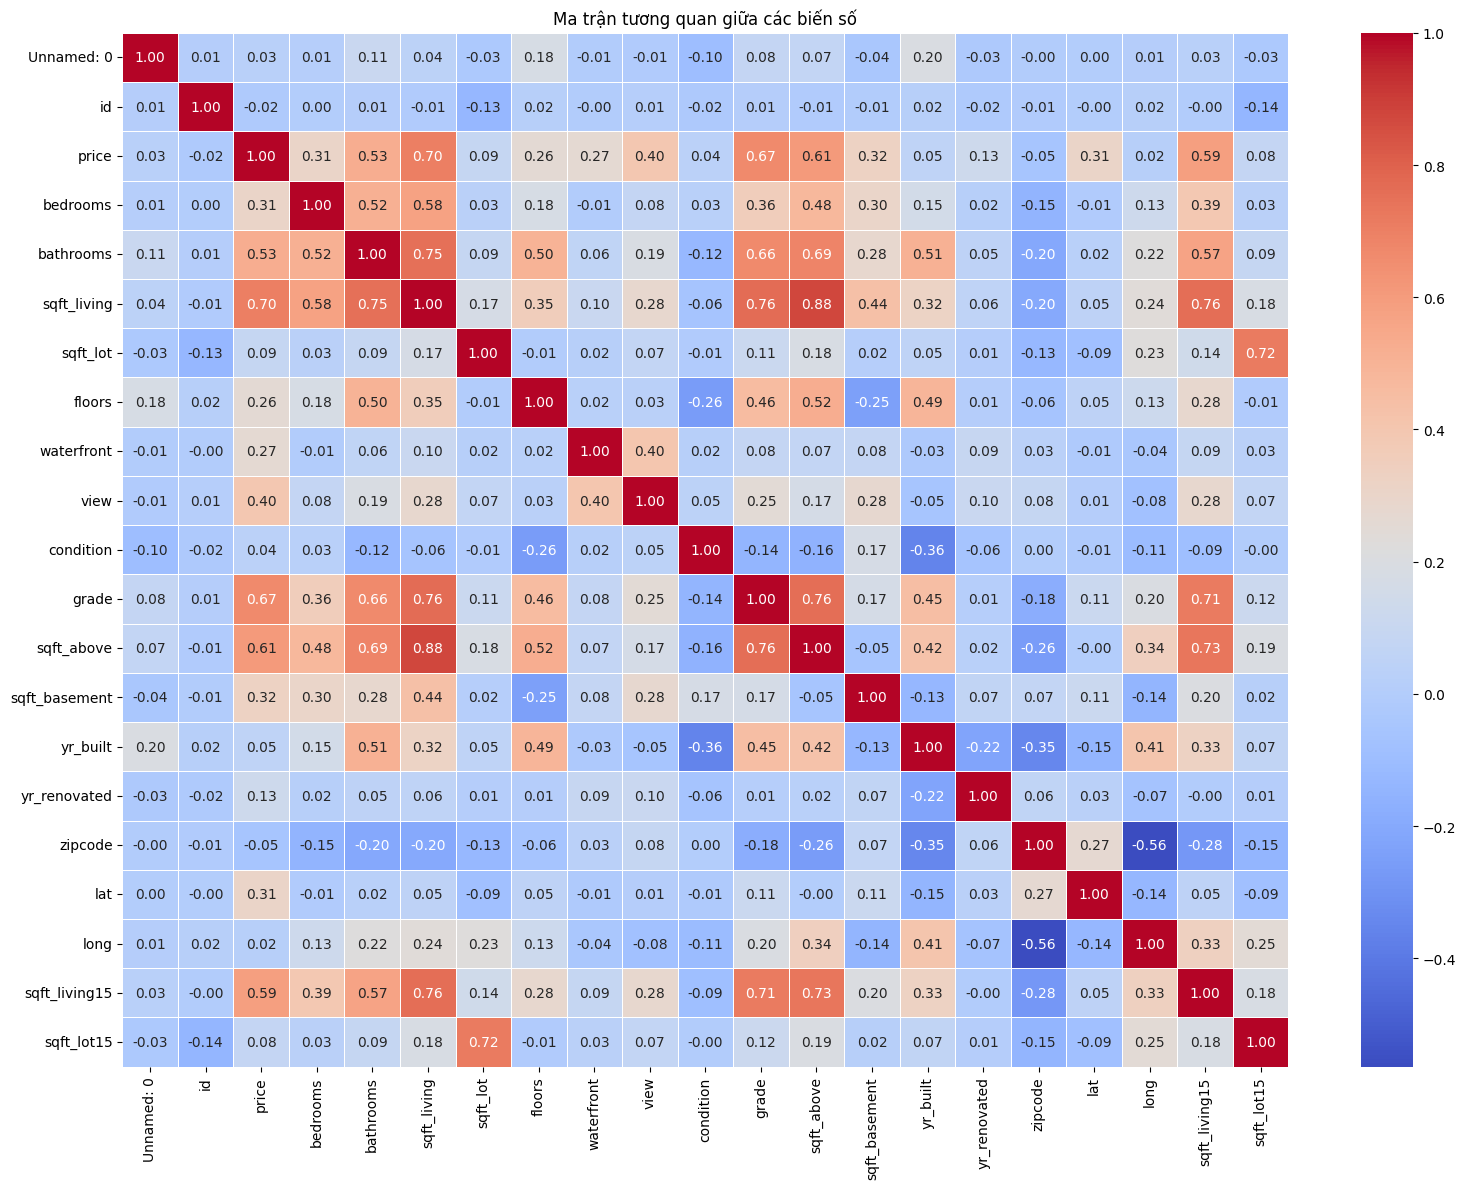

In [13]:
# 3. Trực quan giữa các biến
import seaborn as sns
import numpy as np

# Tính ma trận tương quan
corr_matrix = df.corr(numeric_only=True)

# Vẽ biểu đồ heatmap tương quan
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Ma trận tương quan giữa các biến số")
plt.tight_layout()
plt.show()


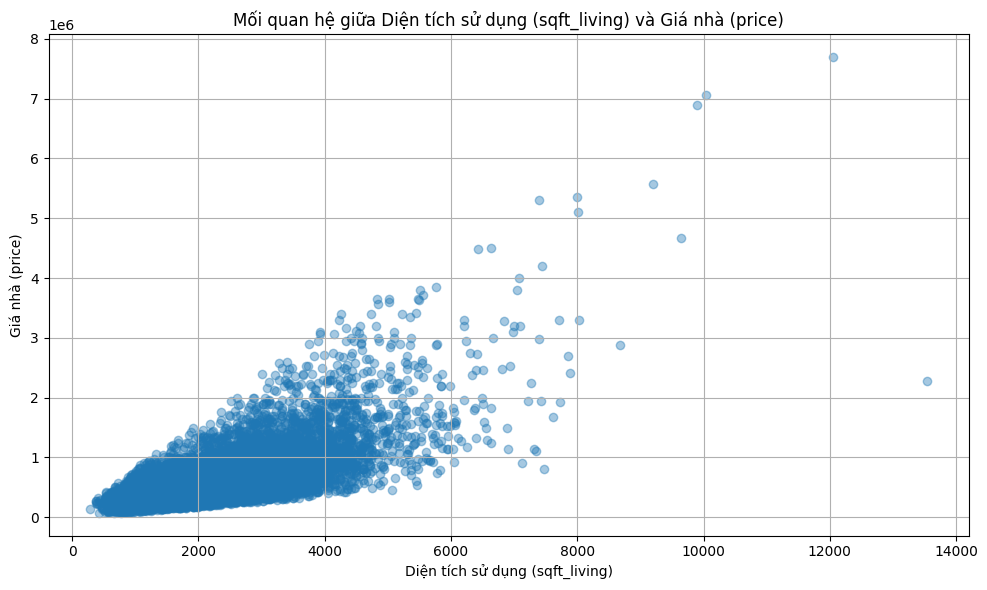

In [14]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ phân tán giữa sqft_living và price
plt.figure(figsize=(10, 6))
plt.scatter(df['sqft_living'], df['price'], alpha=0.4)
plt.title('Mối quan hệ giữa Diện tích sử dụng (sqft_living) và Giá nhà (price)')
plt.xlabel('Diện tích sử dụng (sqft_living)')
plt.ylabel('Giá nhà (price)')
plt.grid(True)
plt.tight_layout()
plt.show()


- Biểu đồ cho thấy mối quan hệ dương giữa diện tích sử dụng (sqft_living) và giá nhà (price). Tức là nhà càng rộng thì thường có giá cao hơn.
- Dữ liệu phân tán khá mạnh và không hoàn toàn tuyến tính
- Có một số điểm ngoại lệ (outliers) — những ngôi nhà có diện tích rất lớn nhưng giá không cao tương xứng, hoặc ngược lại

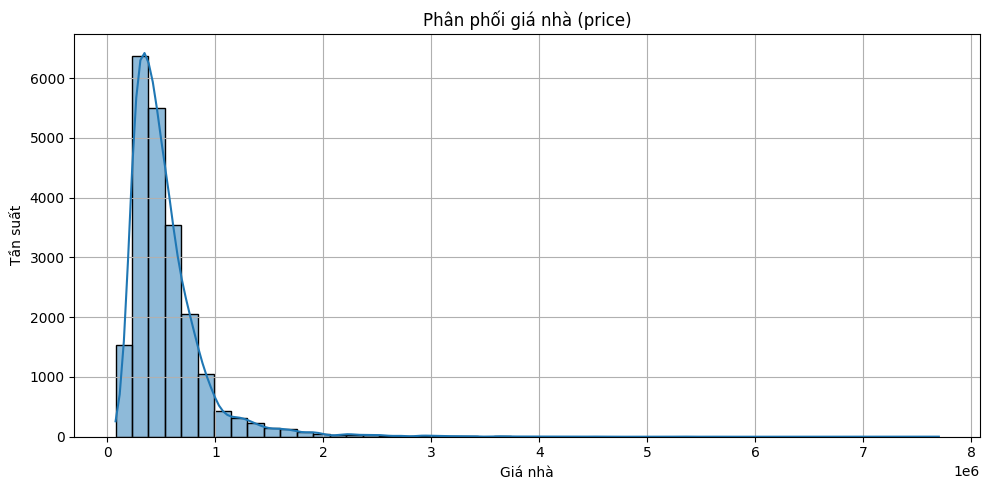

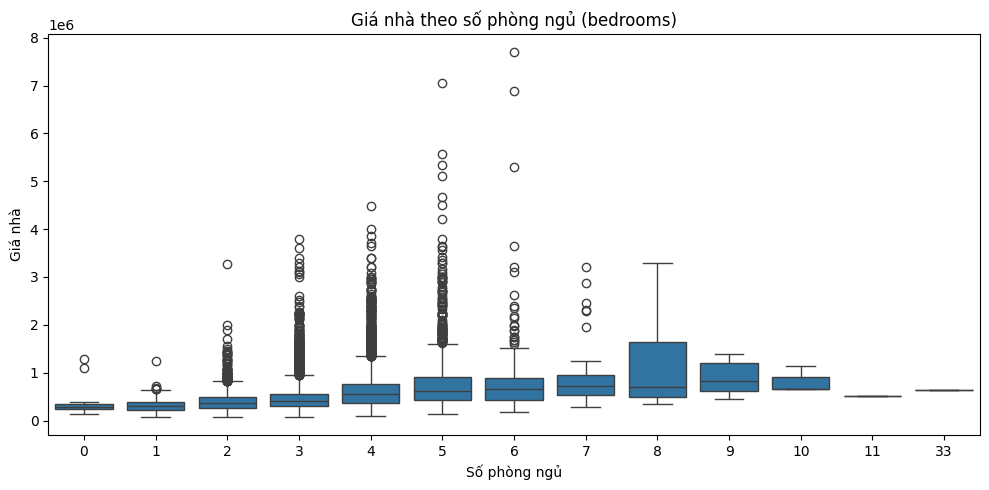

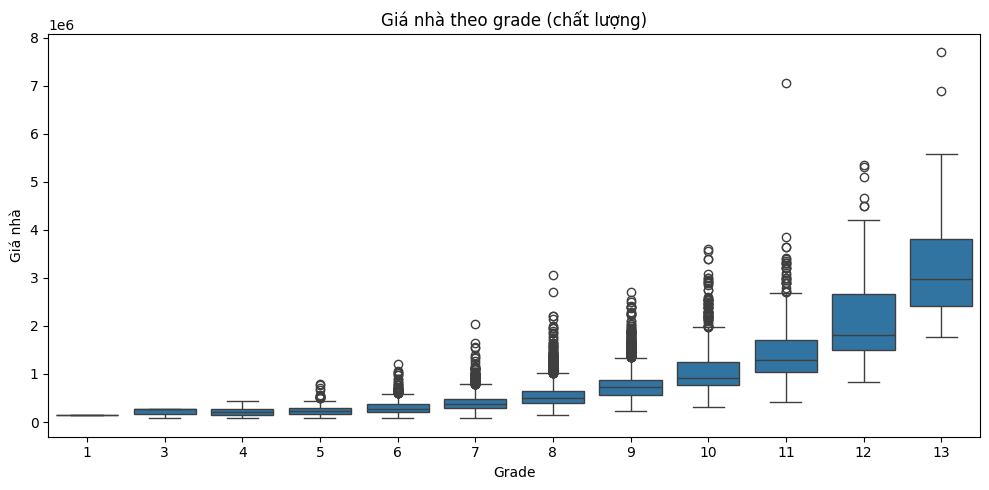

In [15]:
# Vẽ một số biểu đồ trực quan phổ biến: histogram, boxplot, pairplot

import seaborn as sns

# 1. Histogram phân phối giá nhà
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Phân phối giá nhà (price)")
plt.xlabel("Giá nhà")
plt.ylabel("Tần suất")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Boxplot so sánh giá theo số phòng ngủ
plt.figure(figsize=(10, 5))
sns.boxplot(x='bedrooms', y='price', data=df)
plt.title("Giá nhà theo số phòng ngủ (bedrooms)")
plt.xlabel("Số phòng ngủ")
plt.ylabel("Giá nhà")
plt.tight_layout()
plt.show()

# 3. Boxplot so sánh giá theo grade
plt.figure(figsize=(10, 5))
sns.boxplot(x='grade', y='price', data=df)
plt.title("Giá nhà theo grade (chất lượng)")
plt.xlabel("Grade")
plt.ylabel("Giá nhà")
plt.tight_layout()
plt.show()



Phân phối giá nhà (Histogram)
- Giá nhà phân bố lệch phải.

- Phần lớn nhà có giá dưới 1 triệu USD.

- Một số ít nhà có giá rất cao, gây ra đuôi dài

Boxplot: Giá nhà theo số phòng ngủ
- Số phòng ngủ từ 3 đến 5 chiếm đa số.

- Nhà có nhiều hơn 6 phòng ngủ có nhiều điểm ngoại lệ (giá dao động rất lớn).

- Không có xu hướng rõ ràng tăng giá theo số phòng ngủ

Boxplot: Giá nhà theo grade
- grade càng cao, giá nhà càng tăng.
- Grade = 7 và Grade = 8 là phổ biến nhất, hộp boxplot ở 2 mức này rộng và tập trung, cho thấy có nhiều ngôi nhà nằm ở phân khúc trung bình đến khá.

- Các grade từ 7 đến 10 có phân bố giá rất cao.

In [16]:
#  Chọn biến cho Linear Regression đơn giản 
predictors = ['sqft_living', 'grade']
target     = 'price'

print("Predictor variables:", predictors)
print("Target variable:   ", target, "\n")

Predictor variables: ['sqft_living', 'grade']
Target variable:    price 



In [17]:
#  kết nối với sqlite3
conn = sqlite3.connect(':memory:')
df2.to_sql('houses', conn, index=False, if_exists='replace')

summary = pd.read_sql(f"""
  SELECT
    COUNT(*)       AS n,
    AVG({predictors[0]}) AS avg_{predictors[0]},
    AVG({predictors[1]}) AS avg_{predictors[1]},
    AVG({target})       AS avg_{target}
  FROM houses
""", conn)
print(summary, "\n")

       n  avg_sqft_living  avg_grade      avg_price
0  21613      2079.899736   7.656873  540088.141767 



In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X2 = df[['sqft_living', 'grade']]
y2 = df['price']
# Tách tập huấn luyện và kiểm tra
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Huấn luyện mô hình hồi quy
model2 = LinearRegression()
model2.fit(X2_train, y2_train)

# Dự đoán và đánh giá
y2_pred = model2.predict(X2_test)
mse2 = mean_squared_error(y2_test, y2_pred)
r2_2 = r2_score(y2_test, y2_pred)
coefficients2 = model2.coef_
intercept2 = model2.intercept_

(coefficients2, intercept2, mse2, r2_2)


(array([  185.10393866, 96261.37224464]),
 np.float64(-582887.8020468561),
 69834518251.59691,
 0.5380603453464137)

Phương trình hồi quy :
 -  price=185.10×sqft_living+96,261.37×grade−582,887.80


- MSE: ≈ 69.83 tỷ

- R² score: ~0.538
----> Mô hình giải thích được 53.8% phương sai giá nhà

Cả 2 biến sqft_living và grade đều tác động dương đến giá nhà.

- Mỗi 1 sqft diện tích thêm sẽ làm giá nhà tăng khoảng 185 USD.

- Mỗi cấp grade tăng sẽ làm giá tăng thêm trung bình 96,261 USD.

-----> Mô hình phù hợp cho mục đích ước lượng sơ bộ giá nhà.

Câu 3: Giả sử ta muốn biết về tập dữ liệu trong Câu 2 là liệu một ngôi nhà có bán với giá cao (> $300,000) hay với giá thấp (≤ $300,000) hay không. Yêu cầu:
- Hãy áp dụng hồi quy logistic để giải quyết vấn đề này, chỉ sử dụng một biến mà ta nghi ngờ nó ảnh hưởng đến giá nhà để làm biến dự đoán. Gợi ý xem lại slide.
- Từ đó rút ra được những nhận xét gì về dữ liệu và mô hình?

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Gán nhãn: 1 nếu price > 300000, ngược lại là 0
df['classprice'] = (df['price'] > 300000).astype(int)

# Biến đầu vào: diện tích sử dụng
X = df[['sqft_living']]
y = df['classprice']

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hồi quy tuyến tính
model = LinearRegression()
model.fit(X_train, y_train)

# Hệ số
slope = model.coef_[0]
intercept = model.intercept_

# Hàm sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Tính xác suất
z = slope * X_test + intercept
p = sigmoid(z)

# Dự đoán phân lớp
y_pred = (p >= 0.5).astype(int)

# Đánh giá mô hình
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# Kết quả
(slope, intercept, conf_matrix, report)


(np.float64(0.00016662875220173695),
 np.float64(0.4432091203015993),
 array([[   0,  918],
        [   0, 3405]]),
 {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 918.0},
  '1': {'precision': 0.78764746703678,
   'recall': 1.0,
   'f1-score': 0.8812111801242236,
   'support': 3405.0},
  'accuracy': 0.78764746703678,
  'macro avg': {'precision': 0.39382373351839,
   'recall': 0.5,
   'f1-score': 0.4406055900621118,
   'support': 4323.0},
  'weighted avg': {'precision': 0.6203885323294555,
   'recall': 0.78764746703678,
   'f1-score': 0.6940837539493364,
   'support': 4323.0}})

Lớp 0 có 918 mẫu, lớp 1 có 3405 mẫu, tức:
- Số lượng nhà giá cao (> $300,000) chiếm phần lớn (khoảng 79%).
- Trong khi đó, nhà giá thấp (≤ $300,000) chỉ chiếm ~21%
- Mô hình dự đoán 1 chiều khi toàn bộ mẫu test đều được dự đoán là class 1 (giá cao), không có mẫu nào được dự đoán là class 0
- Confusion matrix cho thấy toàn bộ 918 mẫu thuộc lớp 0 đều bị dự đoán sai, trong khi 3.405 mẫu thuộc lớp 1 lại được dự đoán hoàn toàn chính xác.
- Kết quả đánh giá mô hình cho thấy tuy độ chính xác tổng thể (accuracy) đạt 78.76%, nhưng mất cân bằng lớp, bị lệch nghiêm trọng về phía lớp 1.
----> Cách dùng hồi quy tuyến tính + sigmoid mô phỏng logistic ko đạt hiệu quả và không đủ khả năng phân loại trong bài toán này.

Câu 4: Dựa trên bộ dữ liệu Iris, hãy chọn một thuộc tính (chỉ rõ là thuộc tính nào được sử dụng) và phân cụm các giá trị trong thuộc tính đó theo thuật toán K-Means hoặc KNN (chọn 1 trong 2 thuật toán để thử nghiệm).

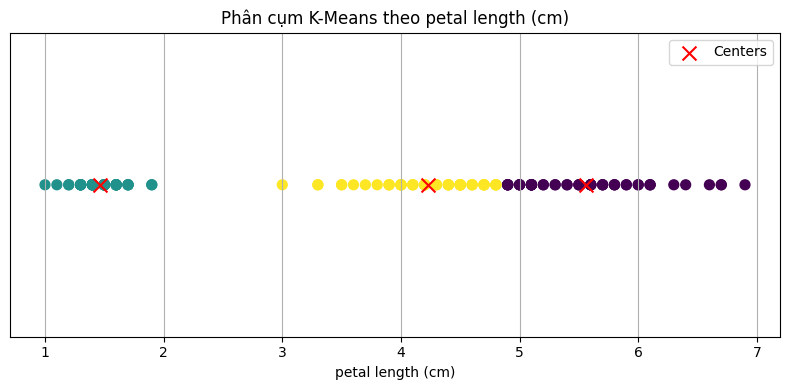

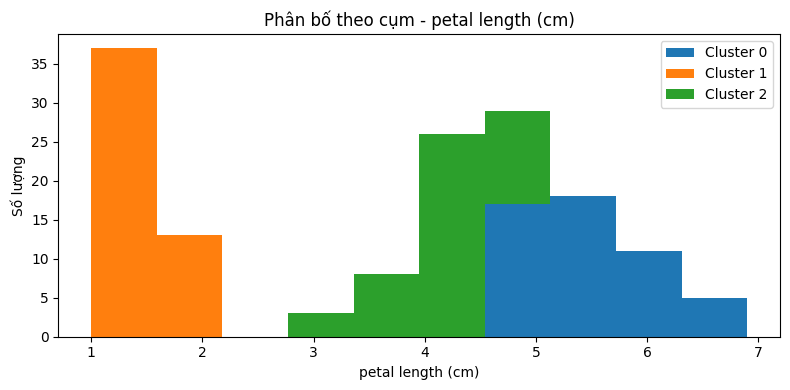

{'Cluster 0': {'center': np.float64(5.56), 'count': np.int64(51)},
 'Cluster 1': {'center': np.float64(1.46), 'count': np.int64(50)},
 'Cluster 2': {'center': np.float64(4.23), 'count': np.int64(49)}}

In [6]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Bước 1: Tải dữ liệu Iris và tạo DataFrame
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

# Bước 2: Chọn thuộc tính để phân cụm: petal length (cm)
attribute_name = 'petal length (cm)'
X = df[[attribute_name]]

# Bước 3: Áp dụng KMeans với 3 cụm (vì tập Iris có 3 loài)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)
cluster_centers = kmeans.cluster_centers_.flatten()

# Bước 4: Vẽ biểu đồ scatter (phân tán điểm theo cụm)
plt.figure(figsize=(8, 4))
plt.scatter(X[attribute_name], [0]*len(X), c=df['cluster'], cmap='viridis', s=50)
plt.scatter(cluster_centers, [0]*len(cluster_centers), c='red', marker='x', s=100, label='Centers')
plt.xlabel(attribute_name)
plt.title(f'Phân cụm K-Means theo {attribute_name}')
plt.yticks([])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Bước 5: Vẽ biểu đồ histogram phân bố theo cụm
plt.figure(figsize=(8, 4))
plt.hist([X[attribute_name][df['cluster'] == i] for i in range(3)],
         bins=10, label=[f'Cluster {i}' for i in range(3)], stacked=True)
plt.title(f'Phân bố theo cụm - {attribute_name}')
plt.xlabel(attribute_name)
plt.ylabel('Số lượng')
plt.legend()
plt.tight_layout()
plt.show()

# Bước 6: Trả kết quả trung tâm các cụm và số lượng mỗi cụm
cluster_counts = df['cluster'].value_counts().sort_index()
cluster_info = {
    f'Cluster {i}': {
        'center': round(cluster_centers[i], 2),
        'count': cluster_counts[i]
    } for i in range(3)
}

cluster_info


- Cluster 0 có trung tâm tại 1.46 cm, tương ứng rất rõ với loài Iris-setosa (cánh hoa rất ngắn).
- Cluster 2 có trung tâm 4.23 cm, nhiều khả năng đại diện cho Iris-versicolor  nhóm trung gian.
Cluster 1 có trung tâm lớn nhất 5.56 cm, phù hợp với Iris-virginica (cánh hoa dài nhất).